In [ ]:
%load_ext autoreload
%autoreload 2

import argparse

import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader.ISPRSPostdam import ISPRSPostdam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
%reload_ext autoreload
from supervised import build_vit_model

model = build_vit_model('dinov2_small', 10)
inp = torch.rand(4, 3, 28, 28)
out = model(inp)
out.shape

Pretrained weight loaded


torch.Size([4, 10, 28, 28])

In [115]:
train_ds = ISPRSPostdam('../dataset/ISPRS-Postdam/splits/train.csv')
val_ds = ISPRSPostdam('../dataset/ISPRS-Postdam/splits/val.csv')
test_ds = ISPRSPostdam('../dataset/ISPRS-Postdam/splits/test.csv')

In [116]:
import yaml
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import matplotlib.cm as cm

def load_color_config(config_path):
    """Load color configuration from YAML file"""
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)

def draw_mask(img, mask, alpha=0.3, class_dict=None, figsize=(5, 4)):
    """
    Display image with mask overlay and legend.
    If class_dict is provided, use the actual RGB colors from it.
    Otherwise, use a colormap for coloring.
    """
    if class_dict is None:
        cmap = cm.get_cmap('viridis')
        use_cmap = True
    else:
        use_cmap = False

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    
    if use_cmap:
        ax.imshow(mask, alpha=alpha, cmap=cmap)
    else:
        # Create colored mask using class_dict colors
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
        unique_labels = np.unique(mask)
        for class_id in unique_labels:
            if class_id in class_dict:
                rgb = class_dict[class_id]['rgb']
                # Normalize RGB values to [0, 1]
                normalized_rgb = tuple(c / 255.0 for c in rgb)
                colored_mask[mask == class_id] = normalized_rgb
        ax.imshow(colored_mask, alpha=alpha)

    handles = []
    unique_label = np.unique(mask)
    
    if use_cmap:
        max_id = max(unique_label)
        for class_id in unique_label:
            label_text = f'Class {class_id}'
            color_norm = class_id / max_id if max_id > 0 else 0
            color = cmap(color_norm)
            patch = mpatches.Patch(color=color, label=label_text)
            handles.append(patch)
    else:
        for class_id in unique_label:
            if class_id in class_dict:
                label_text = class_dict[class_id]['name']
                rgb = class_dict[class_id]['rgb']
                normalized_rgb = tuple(c / 255.0 for c in rgb)
                patch = mpatches.Patch(color=normalized_rgb, label=label_text)
                handles.append(patch)

    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

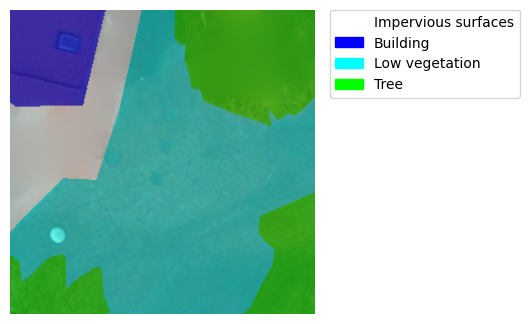

In [117]:
# Load color config and display with actual colors
img, mask = train_ds[0]
color_config = load_color_config('../config/ISPRS-Postdam/color.yaml')
draw_mask(img, mask, alpha=0.5, class_dict=color_config)

In [ ]:
from supervised import train

args = argparse.Namespace(
    config='../config/ISPRS-Postdam/train.yaml',
    save_path='../checkpoints/dinov2_base_isprs_postdam',
)

train(args, train_ds, val_ds)


Training Configuration:
{'backbone': 'dinov2_base',
 'batch_size': 4,
 'conf_thresh': 0.95,
 'config': '../config/ISPRS-Postdam/train.yaml',
 'criterion': {'kwargs': {'ignore_index': 255}, 'name': 'CELoss'},
 'crop_size': 252,
 'dataset': 'ISPRSPostdam',
 'epochs': 180,
 'eval_mode': 'sliding_window',
 'lock_backbone': False,
 'lr': 5e-06,
 'lr_multi': 40.0,
 'model': 'dpt',
 'nclass': 6,
 'ngpus': 1,
 'nsample': 2000,
 'save_path': '../checkpoints/dinov2_base_isprs_postdam'}

Pretrained weight loaded
Total params: 97.5M



Epoch 3: 100%|██████████| 500/500 [01:31<00:00,  5.48it/s, loss=0.437, lr=0.000005]

[Inference] Model loaded on cuda
[Inference] Num classes: 6



Epoch [3/180] Validation Results:
  mIoU: 68.55% | Dice: 80.54% | Acc: 84.89%

✓ New best model saved with mIoU: 68.55%



Epoch 4: 100%|██████████| 500/500 [00:27<00:00, 18.09it/s, loss=0.413, lr=0.000005]


[Inference] Model loaded on cuda
[Inference] Num classes: 6

Epoch [4/180] Validation Results:
  mIoU: 65.95% | Dice: 77.77% | Acc: 84.82%



Epoch 5:  21%|██        | 105/500 [00:05<00:22, 17.49it/s, loss=0.422, lr=0.000005]